### Homework 3: NN Implementation
### 2022 CS 474/574: Deep Learning


#### Tasks:

1. Implement the sofmax function. 5 points

2. Implement the Layer class. 20 points.

3. Complete the NN class. 60 points.

    3.1: implement the 'add' function. 5 points
    
    3.2: implement the cross-entropy loss. 5 points 
    
    3.3: implement the forward propagation process. 5 points.
    
    3.4: implement the prediction function. 5 points
    
    3.5: complete 'train' function. 10 points.
    
    3.6: implement the BP algorithm. 20 points
    
    3.7: update all weights and bias. 5 points
    
    3.8: calculate the accuracy. 5 points 
    
4. Evaluation. 15 points.

In [36]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras # you may need to install tensorflow using 'pip install tensorflow'
from sklearn.model_selection import train_test_split

#### Load the digits dataset

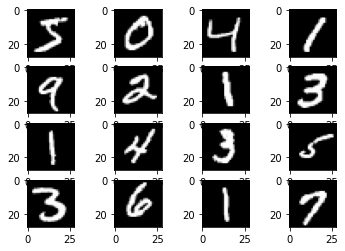

(60000, 784) (10000, 784)


In [37]:
## load the digits dataset
def load_digits(show_sample = True):
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    
    #show first 100 images
    if show_sample == True:
        nImg = 4
        for i in range(nImg*nImg):
            plt.subplot(nImg, nImg, i+1)
            plt.imshow(x_train[i], cmap = 'Greys_r')
        plt.show()
        
    x_train_1 = np.reshape(x_train, [x_train.shape[0], x_train.shape[1] * x_train.shape[2]])
    x_test_1 = np.reshape(x_test, [x_test.shape[0], x_test.shape[1] * x_test.shape[2]])
    x_train_2 = x_train_1/255
    x_test_2 = x_test_1/255
    
    return x_train_2, y_train, x_test_2, y_test

x_train, y_train, x_test, y_test = load_digits()
print(x_train.shape, x_test.shape)

#### Task 1: Activation functions: implement the softmax function. 5 points
Tips:

    -- Refer to chapter 4.1 of the textbook to deal with the underflow overflow problems. 
    -- use the 'axis' and 'keepdims' argument when you use the np.max and np.sum functions

In [38]:
## Task 1: Activation functions: implement the softmax function. 5 points
def sigm(z):
    return 1/(1 + np.exp(-z))

def dsigm(z):
    return sigm(z)*(1 - sigm(z))

def softmax(z):
    ''' softmax function for the output layer.
        The softmax function should be able to work if batch size is greater than 1.

        parameters:
            z: input numpy array. m_batch * 10
        
        return: m_batch * 10     
    '''
    ## add your code here
    e_z = np.exp(z - np.max(z, axis =  0)) 
    norms = e_z.sum(axis = 1)[:,None]
    return e_z / norms
    ##
    
# test the softmax function
z = np.array([[1, 2, 3], [4, 2, 4]])
s = softmax(z)
print(s)

[[0.03511903 0.70538451 0.25949646]
 [0.33333333 0.33333333 0.33333333]]


#### Task 2: Create the layer class. 20 points
    -- Create the Layer class with the constructor function (__init__) and the excution function (run)
    -- Know how to create instances using class

In [39]:
class Layer:
    
    def __init__(self, units, input_dim, activation = None): 
        '''creat a layer and initialize weights and bias. This is the constructor that 
          will be executed automatically when we create a layer instance. 
            
            parameters:
                units: the number of hidden nodes
                input_dim: dimensionality of the layer input
                activation: activation function
                
        '''
        
        self.units = units
        self.activation = activation
        self.input_dim = input_dim
        
        #initialize weights and bias, and their gradients. 10 points.
        #check here: https://www.deeplearning.ai/ai-notes/initialization/
        ## add your code here
        #------------------------
        np.random.seed(0)        

        self.W = np.random.normal(loc = 0, scale = 1/input_dim, size = (input_dim, units))
        self.bias = np.zeros((units,))
        
        #initilize gradients of weights(gW) and bias(gBias)
        self.gW = np.zeros((input_dim, units))
        self.gBias = 0
        
        #-----------------------
        
    def run(self, inputs):
        ''' calculate the net input and activation output of the current layer
        
            inputs: layer input. (n_sample * n_features)
          
            return:
                self.output. the activation output
        '''
        
        ## add your code here
        #-------------------------------------------
        #calculate the net input. 5 points
        self.inputs = inputs
        self.net = np.add(np.dot(inputs, self.W),self.bias)
       
        #calculate activation output. 10 points
        #should deal with both softmax and sigmoid activations
        #use self.activation to choose the activation function of the current layer
        
        if self.activation == 'sigm':
            self.output = sigm(self.net)
            
            
        if self.activation == 'softmax':
            self.output = softmax(self.net)
            
            
        #-----------------------------------------
        
        return self.output

## Test you code to create an NN with two layers 
# create a layer with 20 hidden nodes
L1 = Layer(units = 20, input_dim = 784, activation = 'sigm')
print('L1:', L1.input_dim, L1.units, L1.activation)

# print out the setup of the second layer
h1 = L1.run(x_train)
print('h1:', h1.shape)

L1: 784 20 sigm
h1: (60000, 20)


#### Task 3: complete the following NN class. 60 points

In [40]:
## Task 3: complete the following NN class. 60 points
class NeuralNetwork:
    
    def __init__(self, optimizer = ['SGD','SGDmomentum'], validation_split = 0.1):
        self.layers=[] # list of layers
        self.optimizer = optimizer
        self.val_split = validation_split
        
    # Task 3.1: implement the 'add' function. 5 points     
    def add(self, units, input_dim, activation = 'sigm'):
        '''add one layer to neural network
        
            parameters:
                units: the number of nodes of current layer
                input_dim: input dimension (the number of nodes of the previous layer)
                activation: the activation function
        '''
        
        ## add your code here
        # create and append a new layer the self.layers 
        #
        self.layers.append(Layer(units = units, 
                                  input_dim = input_dim, 
                                  activation=activation))
        
        ##
        
    # Task 3.2: implement the cross-entropy loss. 5 points   
    def loss(self, y_pred, y):
        '''loss function: 1/n_samples*sum_samples(sum_output(-y_k*log(y_pred_k)))
            
            parameters:
                y_pred: predictions(n_samples * 10)
                y: target(one-hot vectors: n_samples * 10)
            return:
                loss
        '''
        
        m = y.shape[0] # the number of samples
        
        ## add your code here  
        
        loss = (1/m)*np.sum(np.sum(-y * np.log(y_pred), axis = 1))
        
        ##
        
        return loss
    
    # Task 3.3: implement the forward propagation process. 5 points.
    def forward_prop(self, inputs):
        '''forward propagation calculates net input and output for all layers
            
            parameters:
                inputs: input data(n_samples * n_features)
            
            return:
                out: the output of the last layer
            
            Tip: call the run function layer by layer
        '''
        
        nLayers = len(self.layers)
        
        ## add your code here
        for i in range(nLayers):
            out =  self.layers[i].run(inputs)
            inputs = out
        ##
        
        return out
    
    # Task 3.4: implement the prediction function. 5 points
    # tip: using np.argmax to convert onehot vectors to categorical values
    def predict_class(self, x):
        '''predict class lables (0, 1, 2, 3, ..., 9) for data samples
        
            parameters:
                x: input(n_samples * n_features) 
            return:
                class labels
        '''
        ##add your code here
        pred = self.forward_prop(inputs = x)
        pred_labels = np.argmax(pred, axis = 1)
        
        return pred_labels
        #  
        ##
        
    # Task 3.5: complete the following 'train' function. 10 points.
    def train(self, inputs, targets, lr = 0.001, batch_size = 32, epochs = 50, momentum = 0.9,
              stop_crit = 0.01):
        '''implement the SGD process and use Back-Propagation algorithm to calculate gradients 
            
            parameters:
                inputs: training samples
                targets: training targets
                lr: learning rate
                batch_size: batch size
                epochs: max number of epochs
                
            return:
                loss_hist
        '''
        #conduct validation train split
        train_inputs, x_valid, train_targets, y_valid = train_test_split(inputs, targets, test_size = self.val_split)
        m = len(train_targets)  
        y_true = targets
        x_true = inputs
        #print(m, targets.shape)
        self.loss_hist = []
        self.val_loss_hist = []
        self.epoch_losses = []
        
        #early stopping
        i = 0
        valid_change_loss = 1
        while (valid_change_loss > stop_crit) and (i+1 < epochs):
            #shuffle the data
            idx = np.arange(m)
            np.random.shuffle(idx)
            inputs = inputs[idx]
            targets = targets[idx]

            self.batch_losses = []
            for b in range(int(m/batch_size)):
                b_start = b*batch_size
                b_end = min((b+1)*batch_size, m)
                
                x_batch = inputs[b_start:b_end, :]
                y_batch = targets[b_start:b_end, :]
                
                ## add your code here
                
                # 1. run forward propagation using the current batch to 
                #    calculate net input and output for all layers
                out = self.forward_prop(inputs = x_batch)
                
                # 2. call BP to calculate all gradients (gW and gBias)
                self.layers[0].histgW = self.layers[0].gW
                self.layers[0].histgBias = self.layers[0].gBias
                self.layers[1].histgW = self.layers[1].gW
                self.layers[1].histgBias = self.layers[1].gBias
                self.BP(x_batch, y_batch)
               
                # 3. update all weights and bias
                self.updateWeights(lr, momentum)
                
            self.batch_losses.append(self.loss(out, y_batch))
            #print('Best Epoch loss = {}'.format(np.min(self.batch_losses)))
                
            self.epoch_losses.append(np.mean(self.batch_losses))
                ##
                
            lr = lr*0.95
            
            ## add your code here
            
            # 4. calculate and record the loss of current epoch
            y_pred_train = self.forward_prop(inputs = x_true)
            y_pred_valid = self.forward_prop(inputs = x_valid)
            L = self.loss(y_pred_train, y_true)
            L_valid = self.loss(y_pred_valid, y_valid)
            if i == 0:
                valid_prev_loss = 0
                train_prev_loss = 0
            else:
                train_prev_loss = self.loss_hist[i-1]
                valid_prev_loss = self.val_loss_hist[i-1]
            valid_change_loss = np.abs(valid_prev_loss - L_valid)
            train_change_loss = np.abs(train_prev_loss - L)
            self.loss_hist.append(L)
            self.val_loss_hist.append(L_valid)
            
            print('Epoch = {}, Training loss = {:.4f}, Validation Loss = {:.4f}, change train loss = {:.6f}, change valid loss = {:.6f}'.format(
                i, self.loss_hist[i], self.val_loss_hist[i], train_change_loss, valid_change_loss))
            i+=1
            
            # 5. print out the loss of current epoch
            
            ##
            
        return self.loss_hist
   
    #Task 3.6: implement the BP algorithm. 20 points
    def BP(self, x, y):
        ''' Back-propagation algorithm. The implementation should be able to calculte
            gradients for a neural network with at least 3 layers.
            
            parameters:
            x: input samples (n_samples * n_features)
            y: onthot vectors (n_samples * 10)
            
        '''
        
        nLayers = len(self.layers)
        m_batch = x.shape[0]
        
        for i in range(nLayers):
            if i == 0:
                # 1. calculate gradients for the hidden-to-output layer. 10 points
                delta_k = self.layers[-(i+1)].output - y
                self.layers[-(i+1)].gW = np.dot(self.layers[-(i+1)].inputs.transpose(), delta_k)
                self.layers[-(i+1)].gBias = np.sum(delta_k, axis = 0)
            else:
                # 2. calculate gradients for the input-to-hidden layers. 10 points
                delta_j = np.dot(delta_k, self.layers[-(i)].W.transpose())*dsigm(self.layers[-(i+1)].output)
                self.layers[-(i+1)].gW = np.dot(x.transpose(), delta_j)
                self.layers[-(i+1)].gBias = np.sum(delta_j, axis = 0)
                
                
            
       
       
       
                

        
        
        
        
                

        
            
    #Task 3.7: update all weights and bias. 5 points            
    def updateWeights(self, lr, momentum = 0.9):
        '''
            parameters:
                lr: learning rate
                
        '''
        nLayers = len(self.layers)
        
        if self.optimizer =='SGD':
            ##add your code here
            for i in range(nLayers):
                self.layers[i].W  = self.layers[i].W - lr*self.layers[i].gW
                self.layers[i].bias = self.layers[i].bias - lr*self.layers[i].gBias
        
        elif self.optimizer =="SGDmomentum":
            for i in range(nLayers):
                self.layers[i].gW = momentum*self.layers[i].histgW+(1-momentum)*(-lr)*self.layers[i].gW
                self.layers[i].gBias = momentum*self.layers[i].histgBias+(1-momentum)*(-lr)*self.layers[i].gBias
                self.layers[i].W  = self.layers[i].W + self.layers[i].gW
                self.layers[i].bias = self.layers[i].bias + self.layers[i].gBias
        ##
            
    # Task 3.8: calculate the accuracy. 5 points           
    def Acc(self, y, y_pred, which = ''):
        '''calculate accuracy
        
            parameters:
                y: target: categorical values (0, 1, ...9). n_samples * 1
                y_pred: prediction: 0,1,2, ..9. n_samples *1
                
            return: acc
            
        
        '''
        error = np.sum(y_pred !=  y)/y.shape[0]
        print(which+" Accuracy = {:.4f}".format(1-error))

#### Task 4: Evaluation. 15 points

Create 3-layer NN.It should have 50 hidden nodes and 10 output nodes. The hidden layer activation is 'sigmoid' and the output layer activation is the 'softmax'. 

In [42]:
# Task 4: Evaluation

# create a 3-layer NN. 5 points
##add you code here
#------------------------------------
nn = NeuralNetwork(optimizer='SGDmomentum')
nn.add(units = 50, input_dim=784, activation='sigm')
nn.add(units = 10, input_dim = 50, activation = 'softmax')
#------------------------------------


# 2. train the NN.  5 points
## add you code here
#------------------------------------
# transform y_train to onehot vectors
y_train_onehot = keras.utils.to_categorical(y_train)
y_test_onehot = keras.utils.to_categorical(y_test)


# train the network
nn.train(x_train, y_train_onehot, lr = 0.0001, epochs=50, batch_size=128, momentum=0.9,
         stop_crit = 0.0009)

#------------------------------------


# 3. calculte and print out the test and training accuracy. 5 points
##add you code here
#---------------------------------------------
preds = nn.predict_class(x_train)
train_acc = nn.Acc(y_train, preds, which = "Training")


#------------------------------------------------
preds_test = nn.predict_class(x_test)
test_acc = nn.Acc(y_test, preds_test, which = 'Testing')

Epoch = 0, Training loss = 2.2921, Validation Loss = 2.2919, change train loss = 2.292076, change valid loss = 2.291887
Epoch = 1, Training loss = 2.2533, Validation Loss = 2.2523, change train loss = 0.038762, change valid loss = 0.039633
Epoch = 2, Training loss = 2.2153, Validation Loss = 2.2043, change train loss = 0.038051, change valid loss = 0.047937
Epoch = 3, Training loss = 2.2671, Validation Loss = 2.2540, change train loss = 0.051850, change valid loss = 0.049675
Epoch = 4, Training loss = 2.0727, Validation Loss = 2.0732, change train loss = 0.194454, change valid loss = 0.180766
Epoch = 5, Training loss = 1.9121, Validation Loss = 1.9244, change train loss = 0.160535, change valid loss = 0.148802
Epoch = 6, Training loss = 1.7395, Validation Loss = 1.7498, change train loss = 0.172620, change valid loss = 0.174657
Epoch = 7, Training loss = 1.5960, Validation Loss = 1.5988, change train loss = 0.143531, change valid loss = 0.150997
Epoch = 8, Training loss = 1.4894, Valid

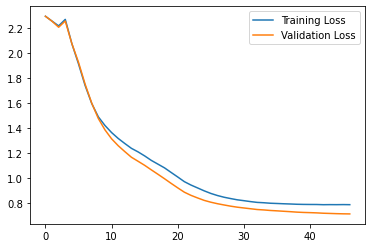

In [48]:
plt.plot(np.arange(len(nn.loss_hist)), nn.loss_hist, label = 'Training Loss')
plt.plot(np.arange(len(nn.val_loss_hist)), nn.val_loss_hist, label = "Validation Loss")
plt.legend()